In [25]:
## MNIST data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# Define a transform to normalize the pixel values
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

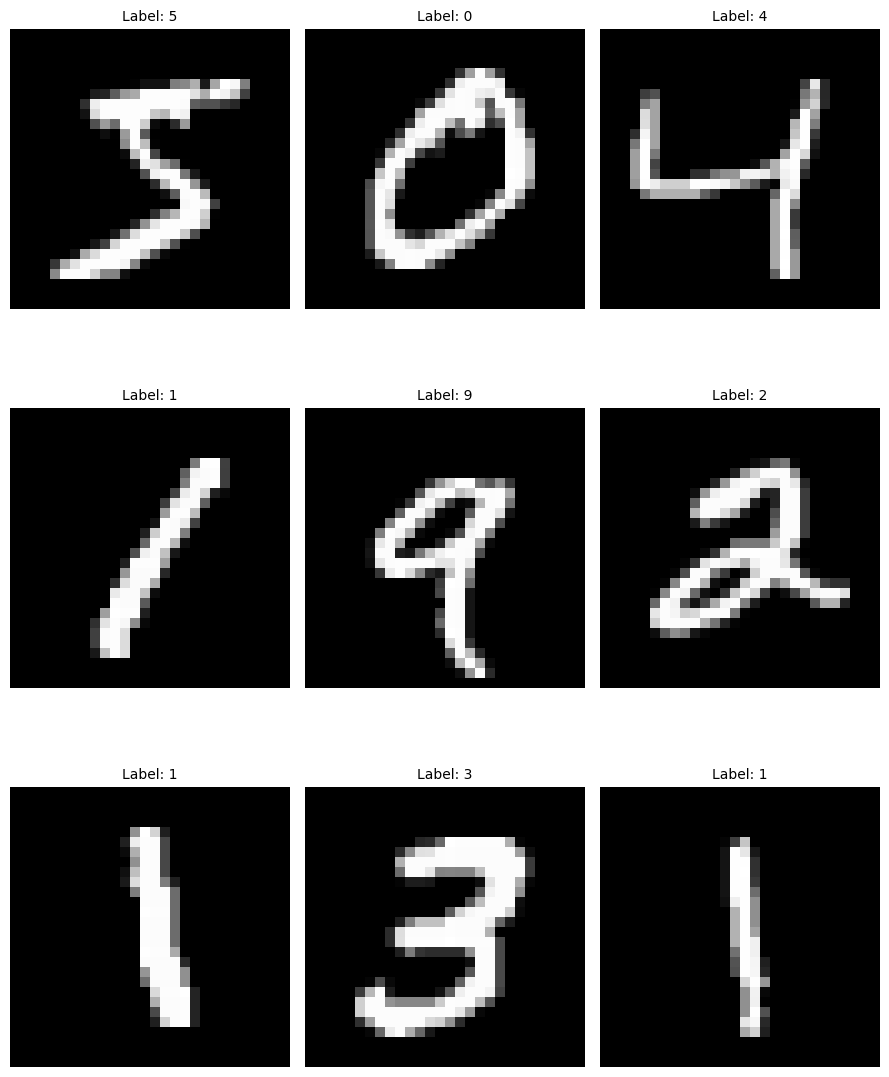

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid: 4 rows x 3 columns (3, 3, 2, 2 layout)
fig, axes = plt.subplots(3, 3, figsize=(9, 12))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

for i in range(9):
    # Get the first image and label from the dataset
    image, label = trainset[i]

    # Denormalize the image (since it was normalized with mean=0.5, std=0.5)
    # Normalize formula: (x - mean) / std, so to denormalize: x * std + mean
    # But since we normalized to [-1, 1], we need: (x + 1) / 2 to get back to [0, 1]
    image = image * 0.5 + 0.5

    # Convert tensor to numpy and remove the channel dimension
    image = image.squeeze().numpy()

    # Display the image in the subplot
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}', fontsize=10)
    axes[i].axis('off')


plt.tight_layout()
plt.show()

### GPU mode

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
from networkx.algorithms.community import modularity, greedy_modularity_communities
from kneed import KneeLocator
import plotly.graph_objects as go
from torchvision import datasets, transforms

class HopfieldEnergyNet(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()
        self.num_neurons = num_neurons
        self.norm = nn.LayerNorm(num_neurons)
        self.weights = nn.Parameter(torch.zeros(num_neurons, num_neurons))
        self.bias = nn.Parameter(torch.zeros(num_neurons))
        nn.init.xavier_uniform_(self.weights)
        self.output_proj = nn.Linear(1, 1)

        # Register positions and distances as buffers
        # This ensures they are moved to the GPU with .to(device)
        positions = torch.zeros(num_neurons, 2)
        positions[:784] = torch.tensor([[i % 28, i // 28] for i in range(784)], dtype=torch.float32)
        positions[784:] = torch.tensor([[28, i % 10] for i in range(216)], dtype=torch.float32)
        self.register_buffer("positions", positions)
        
        distances = torch.cdist(self.positions, self.positions)
        self.register_buffer("distances", distances)

    def energy(self, states):
        interaction = torch.bmm(states.unsqueeze(1), torch.matmul(states, self.weights.transpose(-2, -1)).unsqueeze(2)).squeeze()
        bias_term = torch.matmul(states, self.bias)
        return -0.5 * interaction.mean() - bias_term.mean()

    def forward(self, input_neurons, input_values, output_neurons, steps=20, beta=1.0):
        batch_size = input_values.size(0)
        # self.weights.device ensures new tensors are on the same device (GPU/CPU)
        input_signal = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)
        for i, neuron in enumerate(input_neurons):
            input_signal[:, neuron] = input_values[:, i]
            
        states = torch.zeros(batch_size, self.num_neurons, device=self.weights.device)
        
        for _ in range(steps):
            activation = torch.matmul(states, self.weights) + self.bias + input_signal
            new_states = torch.tanh(beta * activation)
            states = self.norm(states + new_states)
            # --- FIX: Changed inplace += to out-of-place operation ---
            states = states + 0.01 * torch.randn_like(states)
            
        outputs = self.output_proj(states[:, output_neurons].unsqueeze(-1)).squeeze(-1)
        return outputs, states

    def distance_penalty(self, lambda_dist=0.00005):
        # No .to(device) needed, self.distances is already on the correct device
        return lambda_dist * (self.weights.abs() * self.distances).sum()

# --- 1. Set up the device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [ ]:
# Setup
num_neurons = 1000
input_neurons = list(range(784))
output_neurons = list(range(784, 794))

# --- 2. Move model to device ---
model = HopfieldEnergyNet(num_neurons).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# MNIST Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Add num_workers and pin_memory for faster data loading
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, pin_memory=True)

# Training Loop
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # --- 3. Move data batch to device ---
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        data = data.flatten(1)
        outputs, states = model(input_neurons, data, output_neurons)
        loss = F.cross_entropy(outputs, target)
        sparsity_loss = 0.001 * model.weights.abs().sum()
        dist_penalty = model.distance_penalty(lambda_dist=0.0001)
        full_loss = loss + sparsity_loss + dist_penalty
        full_loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss {full_loss.item():.4f}, Dist Penalty {dist_penalty.item():.4f}")

# Inference
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        # --- 4. Move data batch to device ---
        data, target = data.to(device), target.to(device)
        
        data = data.flatten(1)
        outputs, _ = model(input_neurons, data, output_neurons)
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
print(f"Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%")



Epoch 0, Batch 0, Loss 72.6611, Dist Penalty 42.8008
Epoch 0, Batch 100, Loss 2.7128, Dist Penalty 1.1318
Epoch 0, Batch 200, Loss 1.4484, Dist Penalty 0.5456
Epoch 0, Batch 300, Loss 1.1277, Dist Penalty 0.4682
Epoch 0, Batch 400, Loss 1.0403, Dist Penalty 0.4105
Epoch 0, Batch 500, Loss 1.0919, Dist Penalty 0.3876
Epoch 0, Batch 600, Loss 1.0128, Dist Penalty 0.4037
Epoch 0, Batch 700, Loss 1.0716, Dist Penalty 0.3976
Epoch 0, Batch 800, Loss 0.8881, Dist Penalty 0.3756
Epoch 0, Batch 900, Loss 1.0378, Dist Penalty 0.3837
Epoch 1, Batch 0, Loss 1.0073, Dist Penalty 0.4093
Epoch 1, Batch 100, Loss 1.0731, Dist Penalty 0.4084
Epoch 1, Batch 200, Loss 0.9405, Dist Penalty 0.3751
Epoch 1, Batch 300, Loss 1.0086, Dist Penalty 0.3904
Epoch 1, Batch 400, Loss 1.0479, Dist Penalty 0.3638
Epoch 1, Batch 500, Loss 0.8060, Dist Penalty 0.3784
Epoch 1, Batch 600, Loss 0.9248, Dist Penalty 0.3698
Epoch 1, Batch 700, Loss 0.9908, Dist Penalty 0.3871
Epoch 1, Batch 800, Loss 0.9917, Dist Penalty 0.

In [72]:
# Optimized find_best_k
def get_energy_graph(model, k=3000, input_neurons=None, input_values=None, use_states=False):
    if use_states and input_neurons is not None and input_values is not None:
        with torch.no_grad():
            # input_values should be on the same device as model
            _, states = model(input_neurons, input_values, output_neurons)
            states = states.cpu().numpy() # Move to CPU for numpy
            weight_matrix = np.corrcoef(states.T)
            weight_matrix = np.nan_to_num(weight_matrix, 0)
    else:
        # Move weights to CPU for numpy
        weight_matrix = model.weights.data.cpu().numpy()
        weight_matrix = (weight_matrix - weight_matrix.min()) / (weight_matrix.max() - weight_matrix.min() + 1e-8)
        
    print(f"Weight matrix stats: min={weight_matrix.min():.4f}, max={weight_matrix.max():.4f}, std={np.std(weight_matrix):.4f}")
    G = nx.Graph()
    edges = []
    for i in range(model.num_neurons):
        for j in range(i + 1, model.num_neurons):
            edges.append((i, j, weight_matrix[i, j]))
            
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    for i in range(model.num_neurons):
        G.add_node(i)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)
        
    singletons = sum(1 for node in G.nodes() if G.degree(node) == 0)
    print(f"Singletons: {singletons}/{model.num_neurons}")
    return G

def find_best_k(model, min_k=3000, max_k=15000, step=1000, max_components=20, input_neurons=None, input_values=None, use_states=False):
    k_values = []
    mod_values = []
    for k in range(min_k, max_k + 1, step):
        G = get_energy_graph(model, k=k, input_neurons=input_neurons, input_values=input_values, use_states=use_states)
        components = nx.number_connected_components(G)
        communities = greedy_modularity_communities(G, weight='weight')
        current_mod = modularity(G, communities, weight='weight')
        if components <= max_components:
            k_values.append(k)
            mod_values.append(current_mod)
            cluster_sizes = [len(comm) for comm in communities]
            print(f"k={k}: Modularity={current_mod:.4f}, Components={components}, Cluster sizes={cluster_sizes}")
    
    if not k_values:
        print("No valid k found; try increasing max_components or min_k")
        return min_k
    
    kneedle = KneeLocator(k_values, mod_values, curve="convex", direction="decreasing")
    best_k = kneedle.knee if kneedle.knee else k_values[np.argmax(mod_values)]
    print(f"Best balanced k: {best_k} (modularity={max(mod_values):.4f})")
    return best_k

# Visualization
def visualize_3d(G, partition):
    pos_3d = nx.spring_layout(G, dim=3, seed=42)
    edge_x, edge_y, edge_z = [], [], []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=2, color='gray'))
    
    node_x, node_y, node_z = [], [], []
    node_colors = []
    colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'purple', 4: 'orange', 5: 'cyan', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'black'}
    for node in G.nodes():
        x, y, z = pos_3d[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_colors.append(colors.get(partition.get(node, 0), 'gray'))
        
    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', marker=dict(size=10, color=node_colors), text=list(G.nodes()))
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(
        title='3D Emergent Neuron Clusters', 
        width=800,
        height=800,
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='cube')
    ))
    fig.show()

# Run clustering
batch, _ = next(iter(train_loader))
# --- 5. Move clustering batch to device ---
# This is important if you use use_states=True
batch = batch.flatten(1).to(device)

best_k = find_best_k(model, min_k=3000, max_k=15000, step=1000, max_components=20, input_neurons=input_neurons, input_values=batch, use_states=False)
G = get_energy_graph(model, k=best_k, input_neurons=input_neurons, input_values=batch, use_states=False)
communities = greedy_modularity_communities(G, weight='weight')
partition = {node: i for i, comm in enumerate(communities) for node in comm}
print("Detected clusters:", partition)
cluster_sizes = [len(comm) for comm in communities]
print("Cluster sizes:", cluster_sizes)

# Note: The 3D visualization is very slow for 1000 nodes.
visualize_3d(G, partition)

Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 583/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 509/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 440/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 369/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 295/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 219/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 144/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 101/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 59/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 35/1000
Weight matrix stats: min=0.0000, max=1.0000, std=0.0042
Singletons: 19/1000
k=13000: Modularity=0.1837, Components=20, Cluster sizes=[390, 326, 265, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Weight matrix stats: min=0